# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply sensitivity analysis
There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis. 


1. Apply Sobol with 3 seperate release policies (0, 0.05, and 0.1) and analyse the results for each release policy seperately focusing on the reliability objective. Do the sensitivities change depending on the release policy? Can you explain why or why not?

*hint: you can use sobol sampling for the uncertainties, and set policies to a list with the 3 different release policies. Next, for the analysis using logical indexing on the experiment.policy column you can select the results for each seperate release policy and apply sobol to each of the three seperate release policies. If this sounds too complicated, just do it on each release policy seperately.*



In [1]:
from lakemodel_function import lake_problem

from ema_workbench import (Model, RealParameter, ScalarOutcome)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

In [2]:
from ema_workbench import Policy

policies = [Policy('0', **{l.name:0 for l in lake_model.levers}),
            Policy('0.05', **{l.name:0.05 for l in lake_model.levers}),
            Policy('0.1', **{l.name:0.1 for l in lake_model.levers})]

In [4]:
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench.em_framework.evaluators import SOBOL
from ema_workbench.em_framework import get_SALib_problem

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(lake_model) as evaluator:
    experiments, results = evaluator.perform_experiments(100, policies,
                                                         uncertainty_sampling=SOBOL)


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1200 scenarios * 3 policies * 1 model(s) = 3600 experiments
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 720 cases completed
[MainProcess/INFO] 1080 cases completed
[MainProcess/INFO] 1440 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2160 cases completed
[MainProcess/INFO] 2520 cases completed
[MainProcess/INFO] 2880 cases completed
[MainProcess/INFO] 3240 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [5]:
problem = get_SALib_problem(lake_model.uncertainties)
problem

{'num_vars': 5,
 'names': ['b', 'delta', 'mean', 'q', 'stdev'],
 'bounds': [(0.1, 0.45),
  (0.93, 0.99),
  (0.01, 0.05),
  (2.0, 4.5),
  (0.001, 0.005)]}

In [6]:
from SALib.analyze.sobol import analyze

In [7]:
sobol_results = {}
for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    y = results['reliability'][logical]
    indices = analyze(problem, y)
    sobol_results[policy] = indices

In [8]:
indices

{'S1': array([ 4.24042647e-01, -2.07252570e-05,  1.16060557e-02,  8.15021029e-02,
        -2.83874437e-04]),
 'S1_conf': array([3.36978597e-01, 3.36294929e-04, 4.60402791e-02, 8.59817975e-02,
        3.71692854e-04]),
 'ST': array([1.02555444e+00, 1.23128545e-06, 1.34116883e-01, 4.82469664e-01,
        4.47759386e-06]),
 'ST_conf': array([3.98545516e-01, 1.03542550e-06, 1.56995256e-01, 3.18656030e-01,
        3.91031350e-06]),
 'S2': array([[           nan, 1.60218368e-01, 2.51492025e-01, 4.03149555e-01,
         1.60861571e-01],
        [           nan,            nan, 2.32193264e-04, 3.54770656e-04,
         2.29252839e-04],
        [           nan,            nan,            nan, 2.30882618e-02,
         4.25608672e-02],
        [           nan,            nan,            nan,            nan,
         4.91127241e-03],
        [           nan,            nan,            nan,            nan,
                    nan]]),
 'S2_conf': array([[       nan, 0.54843143, 0.57425099, 0.70602303

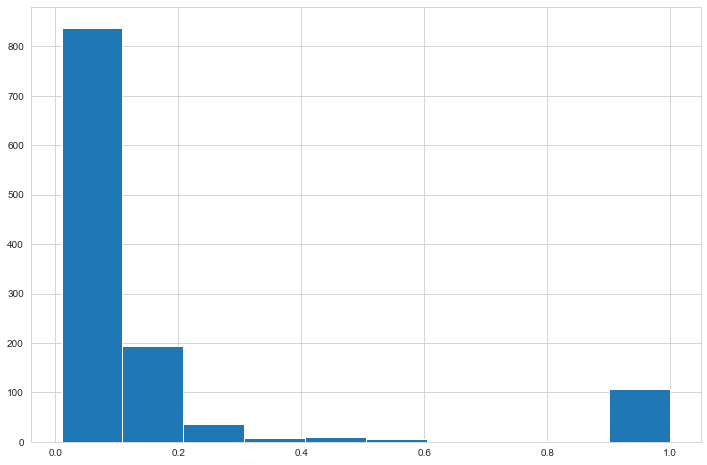

In [9]:
plt.hist(y)
plt.show()

2. Repeat the above analysis for the 3 release policies but now with extra trees feature scoring and for all outcomes of interest. As a bonus, use the sobol experiment results as input for extra trees, and compare the results with those resulting from latin hypercube sampling.

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results*


In [10]:
from ema_workbench.analysis import feature_scoring

In [11]:
cleaned_experiments = experiments.drop(columns=[l.name for l in lake_model.levers])

scores = feature_scoring.get_feature_scores_all(cleaned_experiments,results)

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


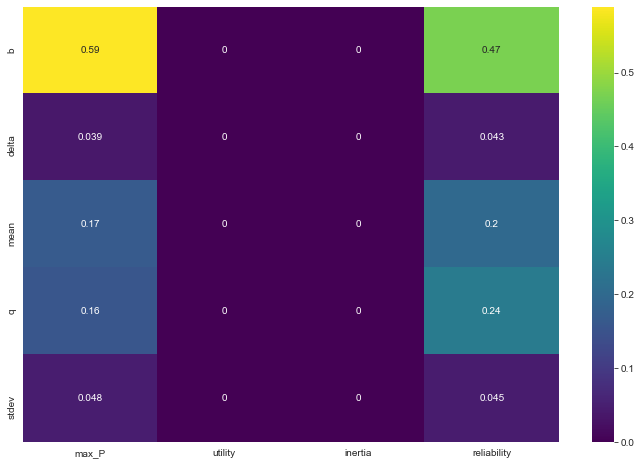

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


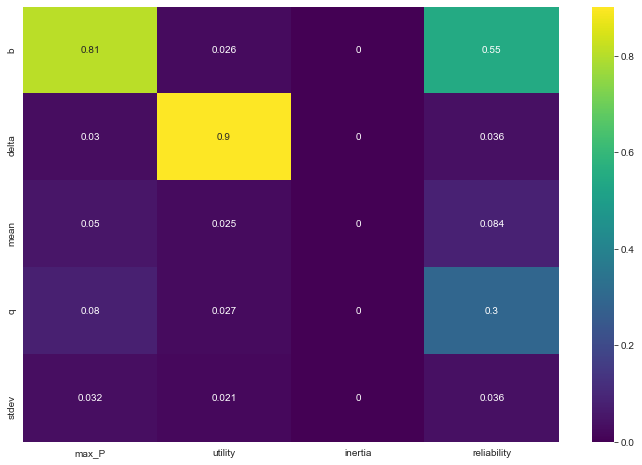

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


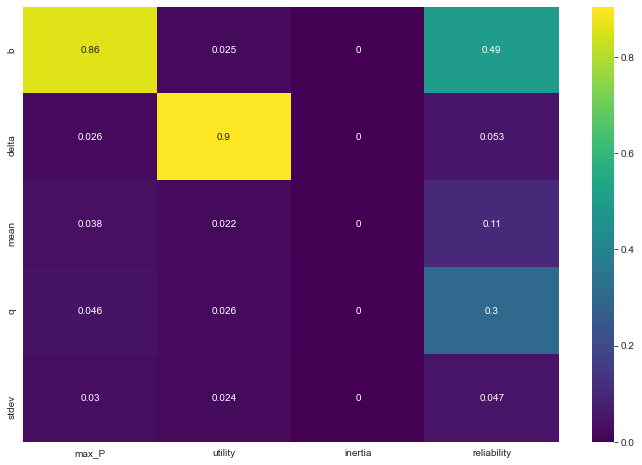

In [12]:
import seaborn as sns
cleaned_experiments = experiments.drop(columns=[l.name for l in lake_model.levers])

for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    subset_results = {k:v[logical] for k,v in results.items()}
    scores = feature_scoring.get_feature_scores_all(cleaned_experiments[logical],
                                                   subset_results)
    sns.heatmap(scores, annot=True, cmap='viridis')
    plt.show()

In [13]:
import statsmodels

In [14]:
y = results['reliability']
x = cleaned_experiments.drop(columns=['scenario', 'policy', 'model'])

model = statsmodels.regression.linear_model.OLS(y, x.values)
fitted = model.fit()

In [15]:
fitted.params

array([ 2.01862814, -0.51308185, -6.39992028,  0.19213615, -4.42897717])

In [ ]:
y = np.a(outcome[:, 1::] < outcome[:, 0], axis=1)